In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import cv2
import cmocean
import cftime
from datetime import datetime, timedelta
import numpy as np
import netCDF4 as nc
import pandas as pd
import pyproj as proj
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.dates as mdates
# import metpy.calc as mpcalc
from scipy import io, interpolate, stats, signal
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree

%matplotlib widget

In [7]:
# Helping Functions
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)

def latlon_to_local(lat, lon, lat_0, lon_0):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

    #Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))
    x, y = proj.transform(crs_wgs, cust, lon, lat)
    return x, y


def local_to_latlon(x, y, lat_0, lon_0):
    # Define projections
    crs_wgs = proj.Proj(init='epsg:4326')  # WGS84 geographic
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))

    # Transform from local AEQD projection back to geographic
    lon, lat = proj.transform(cust, crs_wgs, x, y)
    return lat, lon

def binned_statistics(x, y, bins=10, statistic='median'):
    """
    Bins the x variable into specified intervals, calculates the specified statistic (mean or median)
    of y values within each bin, and returns the statistic values, the bin centers, and the number
    of data points in each bin.

    Parameters:
    - x: array-like, continuous numerical variable to bin
    - y: array-like, continuous numerical variable for which the statistic is calculated within each bin
    - bins: int, the number of bins to create for the x variable
    - statistic: str, 'mean' or 'median' to specify which statistic to calculate

    Returns:
    - bin_centers: array, the center value of each bin
    - statistics: array, the calculated statistic (mean or median) for y values within each bin
    - counts: array, the number of data points in each bin
    """
    
    # Validate the statistic parameter
    if statistic not in ['mean', 'median', 'variance']:
        raise ValueError("Statistic must be 'mean', 'median', or 'variance'.")

    # Create bins
    bin_edges = np.linspace(np.min(x), np.max(x), bins + 1)
    binned_indices = np.digitize(x, bins=bin_edges)

    # Calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate the specified statistic for each bin
    if statistic == 'mean':
        statistics = [np.nanmean(y[binned_indices == i]) for i in range(1, bins + 1)]
    elif statistic == 'median':
        statistics = [np.nanmedian(y[binned_indices == i]) for i in range(1, bins + 1)]
    elif statistic == 'variance':
        statistics = [np.nanvar(y[binned_indices == i]) for i in range(1, bins + 1)]
    
    # Compute std for each bin
    std_in_bin = [np.nanstd(y[binned_indices == i]) for i in range(1, bins + 1)]

    # Check Normal Distribution Goodness of Fit Test for each bin
    
    # Remove NaN values from the 

    # Count the number of data points for each bin
    counts = [np.sum(binned_indices == i) for i in range(1, bins + 1)]

    return np.array(bin_centers), np.array(statistics), np.array(counts), np.array(std_in_bin)

In [8]:
# Add the wave gliders back in
df = pd.read_csv('../data/play1_df.csv')
df = df.dropna(subset=['hs'])
df.head()

# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../data/L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]

# Find index of closest Ice Map - September 10th 
# ind_for_ice_map = 252
ind_for_ice_map = 252
print(ice_map_date[ind_for_ice_map])
ice_concentration = ice_map_conc[:,:,ind_for_ice_map]

# Day 1 - 20% concentration
ice_conc_20percent_day1 = np.zeros(ice_concentration.shape)
ice_conc_20percent_day1[ice_map_conc[:,:,252] >= 15] = 1

# Day 2 - 20% Concentration
ice_conc_20percent_day2 = np.zeros(ice_concentration.shape)
ice_conc_20percent_day2[ice_map_conc[:,:,253]  >= 15] = 1

# Compute Ice Edge Based on 0% Concentration
ice_conc_20percent_day3 = np.zeros(ice_concentration.shape)
ice_conc_20percent_day3[ice_map_conc[:,:,254] >= 15] = 1

# Define the Local Cartesian Coordinate System
lat_0 = 72.48
lon_0 = -151

# Convert Lat lon on Ice Map to cartesian system 
x_icemap, y_icemap = latlon_to_local(ice_map_lat, ice_map_lon, lat_0, lon_0)

# Convert the SWIFT Track Coordinates to the local Cartesian system
x_swifts_gliders, y_swifts_gliders = latlon_to_local(df['latitude'], df['longitude'], lat_0, lon_0)

# Get time values for the SWIFTs
time_swifts = df['time'][:]
datetimes = pd.to_datetime(time_swifts)
date_numbers = np.squeeze(mdates.date2num(datetimes))

# Find the x and y location of the 15% ice concentration
# Find the 15% concentration contour line
ice_edge_contour_lon_vals = ice_map_lon[:,0]
lat_vals = ice_map_lat[0,:]

ice_edge_20percent_day1_contour_lat_vals = []
ice_edge_20percent_day2_contour_lat_vals = []
ice_edge_20percent_day3_contour_lat_vals = []

for n in range(ice_conc_20percent_day1.shape[0]):
    # day 1 
    ice_edge_lat_index_array = np.where(ice_conc_20percent_day1[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_20percent_day1_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_20percent_day1_contour_lat_vals.append(np.nan)
        
    # day 2
    ice_edge_lat_index_array = np.where(ice_conc_20percent_day2[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_20percent_day2_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_20percent_day2_contour_lat_vals.append(np.nan)

    # day 3
    ice_edge_lat_index_array = np.where(ice_conc_20percent_day3[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_20percent_day3_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_20percent_day3_contour_lat_vals.append(np.nan)

# Convert lon values to numpy array
ice_edge_20percent_day1_contour_lat_vals = np.array(ice_edge_20percent_day1_contour_lat_vals)
ice_edge_20percent_day2_contour_lat_vals = np.array(ice_edge_20percent_day2_contour_lat_vals)
ice_edge_20percent_day3_contour_lat_vals = np.array(ice_edge_20percent_day3_contour_lat_vals)


def smooth_ice_contour(lat_vals, lon_vals, lat_0, lon_0):
    # Convert the ice edge values to cartesian and polar coordinates
    x_iceedge, y_iceedge = latlon_to_local(lat_vals, lon_vals, lat_0, lon_0)

    # Interpolate the x and y ice edge values to make a smooth curve of the ice edge
    x_iceedge_interp = np.linspace(-100000, 200000, num=50000)
    y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)

    fs = 1 / (x_iceedge_interp[1] - x_iceedge_interp[0])
    cutoff = 1/40000
    order = 1
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y_iceedge_smoothed = signal.filtfilt(b, a, y_iceedge_interp)

    return x_iceedge_interp, y_iceedge_smoothed

# Smooth the ice concentration contours
x_20percent_day1_contour, y_20percent_day1_contour = smooth_ice_contour(ice_edge_20percent_day1_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)
x_20percent_day2_contour, y_20percent_day2_contour = smooth_ice_contour(ice_edge_20percent_day2_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)
x_20percent_day3_contour, y_20percent_day3_contour = smooth_ice_contour(ice_edge_20percent_day3_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)

2022-09-10 00:00:00


/opt/homebrew/Caskroom/miniforge/base/envs/sassie/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/zp/q_p2q1z11tv6y86pqbxrqqq80000gn/T/ipykernel_41919/2657290664.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)
/opt/homebrew/Caskroom/miniforge/base/envs/sassie/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.git

/opt/homebrew/Caskroom/miniforge/base/envs/sassie/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/sassie/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/sassie/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/sassie/lib/python3.13/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_li

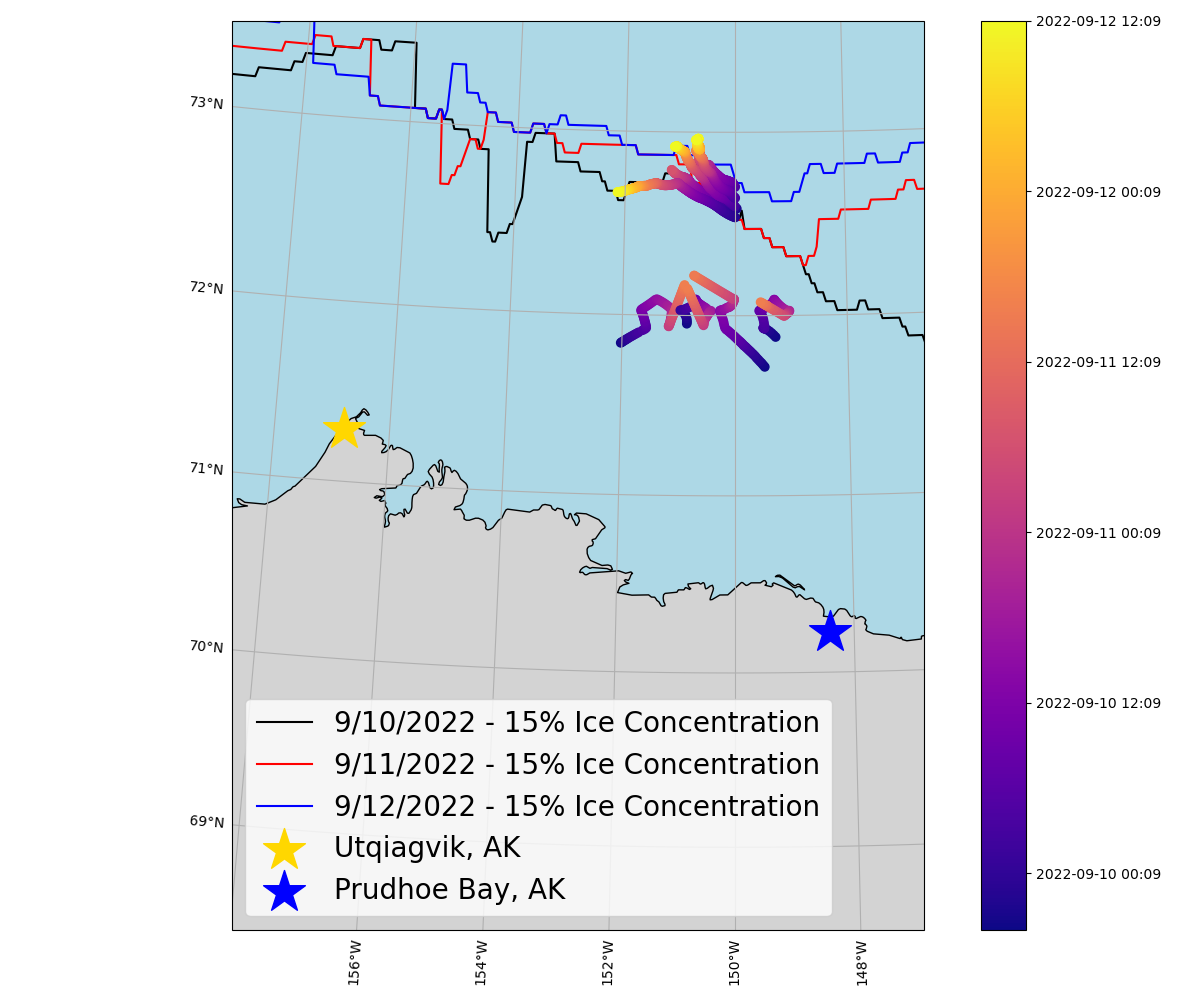

In [9]:
# Create a figure and axis with a projection suitable for Arctic regions
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-150, central_latitude=70))

# Set extent [west, east, south, north]
ax.set_extent([-158, -147, 68.5, 73.5], crs=ccrs.PlateCarree())

# Add land and ocean with natural Earth features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add coastlines and borders for reference
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Optional: Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=-1)
gl.top_labels = False
gl.right_labels = False

# Plot the Ice Concentration Contours
ax.plot(ice_edge_contour_lon_vals, ice_edge_20percent_day1_contour_lat_vals, transform=ccrs.PlateCarree(), color='k', label='9/10/2022 - 15% Ice Concentration', zorder=-1)
ax.plot(ice_edge_contour_lon_vals, ice_edge_20percent_day2_contour_lat_vals, transform=ccrs.PlateCarree(), color='r', label='9/11/2022 - 15% Ice Concentration', zorder=-1)
ax.plot(ice_edge_contour_lon_vals, ice_edge_20percent_day3_contour_lat_vals, transform=ccrs.PlateCarree(), color='b', label='9/12/2022 - 15% Ice Concentration', zorder=-1)
# ax.plot(ice_edge_contour_lon_vals, np.mean(np.array([ice_edge_20percent_day1_contour_lat_vals, ice_edge_20percent_day2_contour_lat_vals, ice_edge_20percent_day3_contour_lat_vals]), axis=0), 
#         transform=ccrs.PlateCarree(), color='k', linestyle='dashed', label='September 12th, 2022 Ice Edge', zorder=-1)

# Plot City and Center of Cartesian System
ax.scatter(-156.78844, 71.2905366, marker='*', s=1000, color='gold', transform=ccrs.PlateCarree(), zorder=2, label='Utqiagvik, AK')
ax.scatter(-148.4000, 70.2269, marker='*', s=1000, color='blue', transform=ccrs.PlateCarree(), zorder=2, label='Prudhoe Bay, AK')
# ax.scatter(lon_0, lat_0, marker='.', s=500, color='r', transform=ccrs.PlateCarree(), zorder=2, label='Cartesian Coordinate System Center')
# Plot SWIFT and Wave Glider Tracks
im = ax.scatter(df['longitude'], df['latitude'], transform=ccrs.PlateCarree(), c=date_numbers, cmap='plasma')
cbar = fig.colorbar(im)
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))

ax.legend(fontsize=20)
ax.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.show()

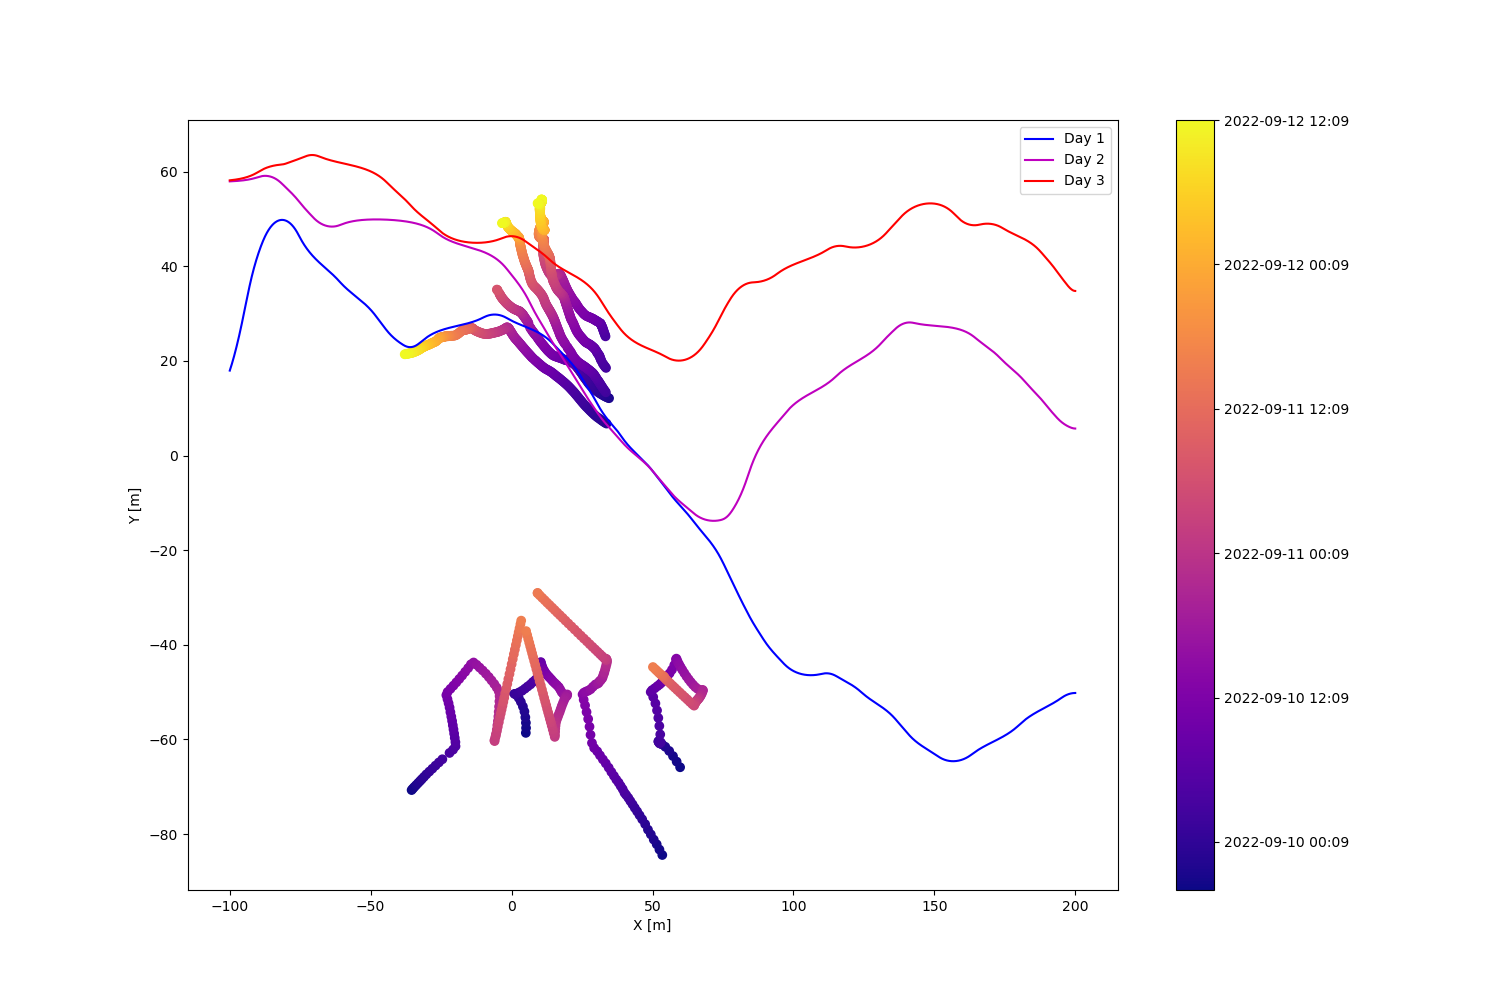

In [10]:
# Plot the Cartesian System
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(x_20percent_day1_contour/1000, y_20percent_day1_contour/1000, color='b', label='Day 1')
ax.plot(x_20percent_day2_contour/1000, y_20percent_day2_contour/1000, color='m', label='Day 2')
ax.plot(x_20percent_day3_contour/1000, y_20percent_day3_contour/1000, color='r', label='Day 3')
im3 = ax.scatter(x_swifts_gliders/1000, y_swifts_gliders/1000, c=date_numbers, cmap='plasma')
cbar2 = fig.colorbar(im3)
cbar2.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%m'))
# cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
# im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    # cmap=cmocean.cm.ice, zorder=0)
# cbar = fig.colorbar(im2)
# cbar.set_label('Presence of Ice')
# ax.set_xlim(-100000, 200000)
# ax.set_ylim(-120000, 200000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()